=== Resultados (Método: SEOBNRv4) ===
Masa estimada (máx SNR): 6.000 M_sun
SNR máximo: 9691.648
Incertidumbre 95% (criterio SNR>=95%): ±0.112 M_sun (rango [5.870, 6.095])
Valor ponderado por SNR: 9.286 M_sun
Valor ponderado por posterior (media): 5.984 M_sun
--- Tiempos ---
Tiempo total de la estimación: 11.214 s
Tiempo total dentro del bucle: 11.214 s
Tiempo promedio por masa: 0.561 s
Tiempo por iteración (primeras 5): ['0.931', '0.841', '0.785', '0.727', '0.684']


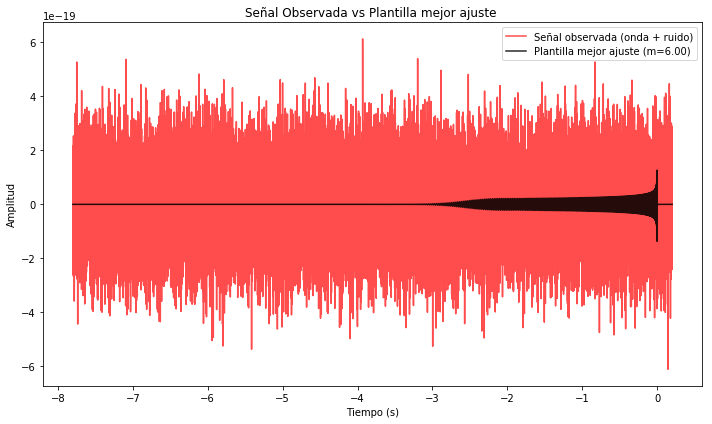

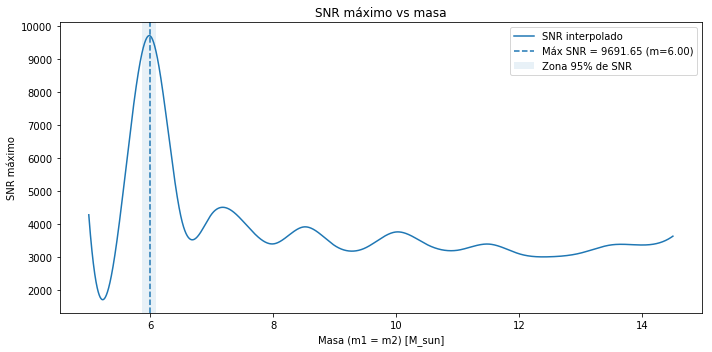

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import time
from pycbc.waveform import get_td_waveform
from pycbc.filter import matched_filter
from pycbc.types import TimeSeries
from pycbc.psd import aLIGOZeroDetHighPower
from scipy.interpolate import interp1d

# ================================
# Configuración reproducible
# ================================
np.random.seed(42)
delta_t = 1.0 / 4096
f_low = 40.0

# ================================
# 1) Señal "real" (onda + ruido)
# ================================
hp_rom, hc_rom = get_td_waveform(
    approximant='SEOBNRv4_ROM',
    mass1=6,
    mass2=6,
    delta_t=delta_t,
    f_lower=f_low
)
t = hp_rom.sample_times.numpy()
signal = np.array(hp_rom)

# Ruido gaussiano escalado
gaussian_noise = np.random.normal(size=len(t))
scaled_noise = gaussian_noise * np.max(np.abs(signal))
observed_signal = signal + scaled_noise
observed_ts = TimeSeries(observed_signal, delta_t=delta_t)

# ================================
# 2) PSD
# ================================
data_fd = observed_ts.to_frequencyseries()
psd = aLIGOZeroDetHighPower(len(data_fd), data_fd.delta_f, 20.0)

# ================================
# 3) Búsqueda por matched filter (m1=m2)
# ================================
masses = np.arange(5.0, 15.0, 0.5)
snr_values = []
iter_times = []

# --- medir tiempo total
t_start_total = time.time()

# --- medir solo el bucle
t_start_loop = time.time()

for m in masses:
    iter_start = time.time()

    hp, _ = get_td_waveform(
        approximant='SEOBNRv4',
        mass1=m,
        mass2=m,
        delta_t=delta_t,
        f_lower=f_low
    )
    hp.resize(len(observed_ts))
    hp_fd = hp.to_frequencyseries()
    snr = matched_filter(hp_fd, data_fd, psd=psd, low_frequency_cutoff=f_low)
    peak_snr = np.abs(snr.numpy()).max()
    snr_values.append(peak_snr)

    iter_end = time.time()
    iter_times.append(iter_end - iter_start)

t_end_loop = time.time()
t_end_total = time.time()

snr_values = np.array(snr_values)
best_idx = np.argmax(snr_values)
best_mass = masses[best_idx]
best_snr = snr_values[best_idx]

# ================================
# 4) Interpolación fina de SNR(m)
# ================================
interp = interp1d(masses, snr_values, kind='cubic')
fine_masses = np.linspace(masses.min(), masses.max(), 5000)
fine_snr = interp(fine_masses)

# --- Incertidumbre 95% (heurística)
mask95 = fine_snr >= 0.95 * best_snr
if np.any(mask95):
    m_lo_95 = fine_masses[mask95].min()
    m_hi_95 = fine_masses[mask95].max()
    half_width_95 = 0.5 * (m_hi_95 - m_lo_95)
else:
    m_lo_95 = best_mass
    m_hi_95 = best_mass
    half_width_95 = 0.0

# --- Posterior discreto: p(m) ∝ exp(0.5 * SNR(m)^2)
rho2 = fine_snr**2
rho2_shift = rho2 - rho2.max()
w_post = np.exp(0.5 * rho2_shift)
post = w_post / w_post.sum()

# Media posterior y IC 68%
mean_post = np.sum(fine_masses * post)
cdf = np.cumsum(post)
m16 = np.interp(0.16, cdf, fine_masses)
m84 = np.interp(0.84, cdf, fine_masses)

# --- Ponderados
mass_weighted_snr = np.sum(fine_masses * fine_snr) / np.sum(fine_snr)
mass_weighted_post = mean_post

# ================================
# 5) Estadísticas de tiempo
# ================================
total_time = t_end_total - t_start_total
loop_time = t_end_loop - t_start_loop
avg_time = loop_time / len(masses)

# ================================
# 6) Reporte completo
# ================================
print(u"=== Resultados (Método: SEOBNRv4) ===")
print(u"Masa estimada (máx SNR): {:.3f} M_sun".format(best_mass))
print(u"SNR máximo: {:.3f}".format(best_snr))
print(u"Incertidumbre 95% (criterio SNR>=95%): ±{:.3f} M_sun (rango [{:.3f}, {:.3f}])"
      .format(half_width_95, m_lo_95, m_hi_95))      
print(u"Valor ponderado por SNR: {:.3f} M_sun".format(mass_weighted_snr))
print(u"Valor ponderado por posterior (media): {:.3f} M_sun".format(mass_weighted_post))
print("--- Tiempos ---")
print(u"Tiempo total de la estimación: {:.3f} s".format(total_time))
print("Tiempo total dentro del bucle: {:.3f} s".format(loop_time))
print("Tiempo promedio por masa: {:.3f} s".format(avg_time))
print("Tiempo por iteración (primeras 5): {}".format(
    [ "{:.3f}".format(x) for x in iter_times[:5] ]))

# ================================
# 7) Gráfico 1: señal vs plantilla óptima
# ================================
hp_best, _ = get_td_waveform(
    approximant='SEOBNRv4_ROM',
    mass1=best_mass,
    mass2=best_mass,
    delta_t=delta_t,
    f_lower=f_low
)
hp_best.resize(len(observed_ts))

plt.figure(figsize=(10,6))
plt.plot(t, observed_signal, label=u"Señal observada (onda + ruido)", color='red', alpha=0.7)
plt.plot(hp_best.sample_times, hp_best,
         label="Plantilla mejor ajuste (m={:.2f})".format(best_mass), color='black', alpha=0.85)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title(u"Señal Observada vs Plantilla mejor ajuste ")
plt.legend()
plt.tight_layout()
plt.show()

# ================================
# 8) Gráfico 2: SNR vs masa
# ================================
plt.figure(figsize=(10,5))
plt.plot(fine_masses, fine_snr, label="SNR interpolado")
plt.axvline(best_mass, linestyle='--',
            label=u"Máx SNR = {:.2f} (m={:.2f})".format(best_snr, best_mass))
plt.axvspan(m_lo_95, m_hi_95, alpha=0.1,
            label="Zona 95% de SNR")
plt.xlabel("Masa (m1 = m2) [M_sun]")
plt.ylabel(u"SNR máximo")
plt.title(u"SNR máximo vs masa")
plt.legend()
plt.tight_layout()
plt.show()

=== Resultados (Método: SEOBNRv4_ROM) ===
Masa estimada (máx SNR): 6.000 M_sun
SNR máximo: 9749.172
Incertidumbre 95% (criterio SNR>=95%): ±0.112 M_sun (rango [5.870, 6.095])
Valor ponderado por SNR: 9.291 M_sun
Valor ponderado por posterior (media): 5.984 M_sun
--- Tiempos ---
Tiempo total de la estimación: 1.095 s
Tiempo total dentro del bucle: 1.095 s
Tiempo promedio por masa: 0.055 s
Tiempo por iteración (primeras 5): ['0.072', '0.066', '0.054', '0.060', '0.054']


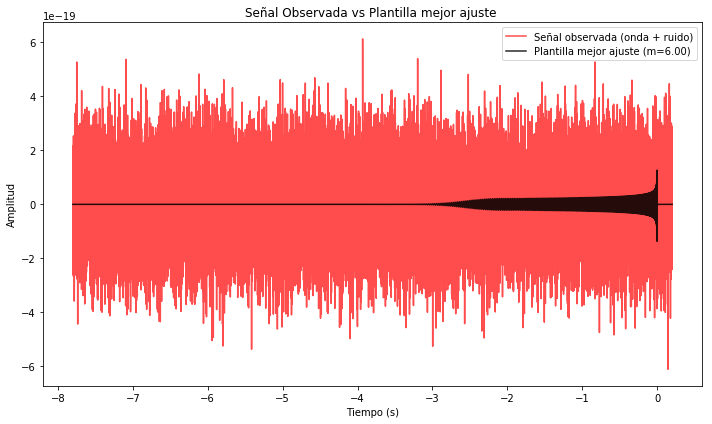

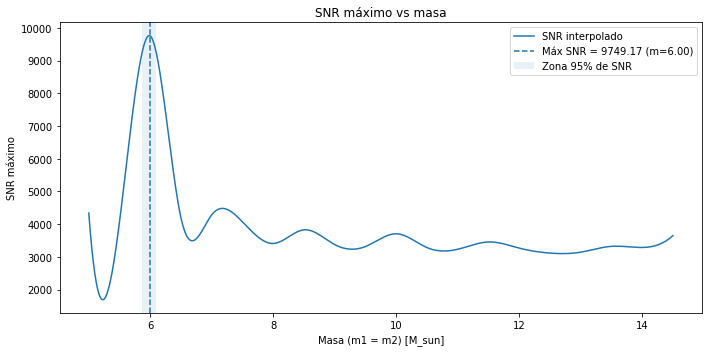

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import time
from pycbc.waveform import get_td_waveform
from pycbc.filter import matched_filter
from pycbc.types import TimeSeries
from pycbc.psd import aLIGOZeroDetHighPower
from scipy.interpolate import interp1d

# ================================
# Configuración reproducible
# ================================
np.random.seed(42)
delta_t = 1.0 / 4096
f_low = 40.0

# ================================
# 1) Señal "real" (onda + ruido)
# ================================
hp_rom, hc_rom = get_td_waveform(
    approximant='SEOBNRv4_ROM',
    mass1=6,
    mass2=6,
    delta_t=delta_t,
    f_lower=f_low
)
t = hp_rom.sample_times.numpy()
signal = np.array(hp_rom)

# Ruido gaussiano escalado
gaussian_noise = np.random.normal(size=len(t))
scaled_noise = gaussian_noise * np.max(np.abs(signal))
observed_signal = signal + scaled_noise
observed_ts = TimeSeries(observed_signal, delta_t=delta_t)

# ================================
# 2) PSD
# ================================
data_fd = observed_ts.to_frequencyseries()
psd = aLIGOZeroDetHighPower(len(data_fd), data_fd.delta_f, 20.0)

# ================================
# 3) Búsqueda por matched filter (m1=m2)
# ================================
masses = np.arange(5.0, 15.0, 0.5)
snr_values = []
iter_times = []

# --- medir tiempo total
t_start_total = time.time()

# --- medir solo el bucle
t_start_loop = time.time()

for m in masses:
    iter_start = time.time()

    hp, _ = get_td_waveform(
        approximant='SEOBNRv4_ROM',
        mass1=m,
        mass2=m,
        delta_t=delta_t,
        f_lower=f_low
    )
    hp.resize(len(observed_ts))
    hp_fd = hp.to_frequencyseries()
    snr = matched_filter(hp_fd, data_fd, psd=psd, low_frequency_cutoff=f_low)
    peak_snr = np.abs(snr.numpy()).max()
    snr_values.append(peak_snr)

    iter_end = time.time()
    iter_times.append(iter_end - iter_start)

t_end_loop = time.time()
t_end_total = time.time()

snr_values = np.array(snr_values)
best_idx = np.argmax(snr_values)
best_mass = masses[best_idx]
best_snr = snr_values[best_idx]

# ================================
# 4) Interpolación fina de SNR(m)
# ================================
interp = interp1d(masses, snr_values, kind='cubic')
fine_masses = np.linspace(masses.min(), masses.max(), 5000)
fine_snr = interp(fine_masses)

# --- Incertidumbre 95% (heurística)
mask95 = fine_snr >= 0.95 * best_snr
if np.any(mask95):
    m_lo_95 = fine_masses[mask95].min()
    m_hi_95 = fine_masses[mask95].max()
    half_width_95 = 0.5 * (m_hi_95 - m_lo_95)
else:
    m_lo_95 = best_mass
    m_hi_95 = best_mass
    half_width_95 = 0.0

# --- Posterior discreto: p(m) ∝ exp(0.5 * SNR(m)^2)
rho2 = fine_snr**2
rho2_shift = rho2 - rho2.max()
w_post = np.exp(0.5 * rho2_shift)
post = w_post / w_post.sum()

# Media posterior y IC 68%
mean_post = np.sum(fine_masses * post)
cdf = np.cumsum(post)
m16 = np.interp(0.16, cdf, fine_masses)
m84 = np.interp(0.84, cdf, fine_masses)

# --- Ponderados
mass_weighted_snr = np.sum(fine_masses * fine_snr) / np.sum(fine_snr)
mass_weighted_post = mean_post

# ================================
# 5) Estadísticas de tiempo
# ================================
total_time = t_end_total - t_start_total
loop_time = t_end_loop - t_start_loop
avg_time = loop_time / len(masses)

# ================================
# 6) Reporte completo
# ================================
print(u"=== Resultados (Método: SEOBNRv4_ROM) ===")
print(u"Masa estimada (máx SNR): {:.3f} M_sun".format(best_mass))
print(u"SNR máximo: {:.3f}".format(best_snr))
print(u"Incertidumbre 95% (criterio SNR>=95%): ±{:.3f} M_sun (rango [{:.3f}, {:.3f}])"
      .format(half_width_95, m_lo_95, m_hi_95))      
print(u"Valor ponderado por SNR: {:.3f} M_sun".format(mass_weighted_snr))
print(u"Valor ponderado por posterior (media): {:.3f} M_sun".format(mass_weighted_post))
print("--- Tiempos ---")
print(u"Tiempo total de la estimación: {:.3f} s".format(total_time))
print("Tiempo total dentro del bucle: {:.3f} s".format(loop_time))
print("Tiempo promedio por masa: {:.3f} s".format(avg_time))
print("Tiempo por iteración (primeras 5): {}".format(
    [ "{:.3f}".format(x) for x in iter_times[:5] ]))

# ================================
# 7) Gráfico 1: señal vs plantilla óptima
# ================================
hp_best, _ = get_td_waveform(
    approximant='SEOBNRv4_ROM',
    mass1=best_mass,
    mass2=best_mass,
    delta_t=delta_t,
    f_lower=f_low
)
hp_best.resize(len(observed_ts))

plt.figure(figsize=(10,6))
plt.plot(t, observed_signal, label=u"Señal observada (onda + ruido)", color='red', alpha=0.7)
plt.plot(hp_best.sample_times, hp_best,
         label="Plantilla mejor ajuste (m={:.2f})".format(best_mass), color='black', alpha=0.85)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title(u"Señal Observada vs Plantilla mejor ajuste ")
plt.legend()
plt.tight_layout()
plt.show()

# ================================
# 8) Gráfico 2: SNR vs masa
# ================================
plt.figure(figsize=(10,5))
plt.plot(fine_masses, fine_snr, label="SNR interpolado")
plt.axvline(best_mass, linestyle='--',
            label=u"Máx SNR = {:.2f} (m={:.2f})".format(best_snr, best_mass))
plt.axvspan(m_lo_95, m_hi_95, alpha=0.1,
            label="Zona 95% de SNR")
plt.xlabel("Masa (m1 = m2) [M_sun]")
plt.ylabel(u"SNR máximo")
plt.title(u"SNR máximo vs masa")
plt.legend()
plt.tight_layout()
plt.show()
